In [17]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quilt
from quilt.data.elijahc import ripc

from sklearn.manifold import TSNE,Isomap

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

In [2]:
pop_df = ripc.population_fc_stats()
pop_df = pop_df.dropna()
pop_df.tail()

,min,Molecular_Weight,log2fc_mean,log2fc_var,p-value
726485,60,268.20519,0.094736,0.812804,0.569362
726486,60,190.17731,-0.092935,0.587453,0.511858
726487,60,150.14178,-0.099776,1.926829,0.696683
726488,60,568.38420,-0.024295,0.092641,0.665231
726489,60,268.20540,-0.367258,0.681297,0.021178


## Extract compounds that have statistically significant p-values at all timepoints after 10min

In [23]:
timepoint_dfs = []
for t in [10,20,30,45,60]:
    t_df = pop_df.query("min == {}".format(t))
    timepoint_dfs.append(t_df[t_df['p-value'] <= 0.01])
tp_mol_w_dfs = [np.unique(df['Molecular_Weight'].values) for df in timepoint_dfs]

In [24]:
# Keep only compounts that appear in all 5 timepoints
u_idx = tp_mol_w_dfs[-1]
for arr in tp_mol_w_dfs[-2::-1]:
    u_idx = np.intersect1d(u_idx,arr)
print(len(u_idx))

2961


In [25]:
def set_filter(df,column,criteria):
    return df[df[column].isin(criteria)]

In [26]:
pop_df_short = set_filter(pop_df,'Molecular_Weight',u_idx)

In [27]:
comp_ts_profile = pop_df_short.pivot_table(columns='min',index='Molecular_Weight',values='log2fc_mean')

In [28]:
X = comp_ts_profile.values

In [29]:
X_embedded = TSNE(n_components=2,verbose=1,n_iter=5000).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2961 samples in 0.003s...
[t-SNE] Computed neighbors for 2961 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2961
[t-SNE] Computed conditional probabilities for sample 2000 / 2961
[t-SNE] Computed conditional probabilities for sample 2961 / 2961
[t-SNE] Mean sigma: 0.067215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.903732
[t-SNE] Error after 5000 iterations: 1.185657


In [30]:
tsne_df = pd.DataFrame(X_embedded,index=comp_ts_profile.index,columns=['tsne_1','tsne_2']).reset_index()
tsne_df.head(2)

,Molecular_Weight,tsne_1,tsne_2
0,66.98955,15.387590,-23.550970
1,67.98743,5.362276,46.999119


In [31]:
X_embedded = Isomap(n_neighbors=7,n_components=2).fit_transform(X)

In [32]:
isomap_df = pd.DataFrame(X_embedded,index=comp_ts_profile.index,columns=['isomap_1','isomap_2']).reset_index()
isomap_df.head(2)

,Molecular_Weight,isomap_1,isomap_2
0,66.98955,-0.251765,0.195878
1,67.98743,0.652530,0.139956


In [33]:
subset = isomap_df['Molecular_Weight'].values
merge_df = pop_df[pop_df['Molecular_Weight'].isin(subset)].merge(isomap_df,on='Molecular_Weight')

In [34]:
merge_df.to_pickle('../data/isomap_0.01.pk')

In [38]:
from bokeh.palettes import Plasma256
from bokeh.transform import log_cmap
from bokeh.models import LassoSelectTool

mapper = log_cmap(field_name='Molecular_Weight', palette=Plasma256 ,low=min(tsne_df['Molecular_Weight'].values) ,high=max(tsne_df['Molecular_Weight'].values))

def plot_cluster(x,y,hue=None,data=None,tools='hover,save,reset,pan,lasso_select,wheel_zoom',**kwargs):
    X_vals = data[x]
    Y_vals = data[y]
    source = ColumnDataSource(data)
    p = bp.figure(tools=tools, x_range=(min(X_vals),max(X_vals)), y_range=(min(Y_vals),max(Y_vals)))
    p.hover.tooltips = [
        ("Molecular Weight", "@{Molecular_Weight}"),
    ]
    p.circle(x,y, line_color=hue, color=hue, size=5,source=source)
    
    return p


In [39]:
bp.output_notebook()
p = plot_cluster('isomap_1','isomap_2',hue=mapper,data=isomap_df)
bp.show(p)

Loading BokehJS ...

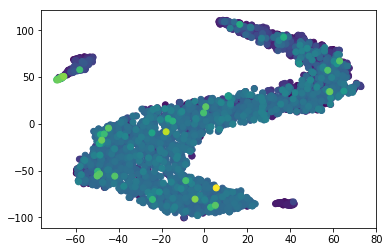

In [16]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=comp_ts_profile.index.values)